# Ensamblar y calcular ganancia

### Autor: Federico Picado
### Fecha de última modificación: 28/10/2024
### Descripción:

Podemos evaluar la ganancia de un modelo en particular, ordenado de distinta forma.
Tambien podemos realizar ensambles entre modelos y evaluar su ganancia. 

## Parámetros

## Input

In [1]:
# Ya en el input se ejecutan cosas
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
base_path = '/home/fedepicado/'
modelos_path = base_path + 'buckets/b1/exp/'
predicciones_path = base_path + 'buckets/b1/predicciones/'
db_path = base_path + 'buckets/b1/db/'
dataset_path = base_path + 'buckets/b1/datasets/'
dataset_file = 'competencia_02.parquet'
full_path = dataset_path + dataset_file

# nombre de la carpeta donde se guardaron los resultados para cada modelo segun la metrica
dataset_folder1="modelo_base"


In [3]:
data = pd.read_parquet(dataset_path + dataset_file)

## Output

< Archivos, bases de datos, modelos que va a generar el job>

In [98]:
# en este ultimo jobs se evalua la performance del modelo.

# MAIN

In [4]:
# Crear un diccionario para almacenar los DataFrames
dataframes = {}

# Función para cargar los CSV de una carpeta específica y asignarlos a variables
def cargar_csv_de_carpeta(dataset_folder):
    folder_path = os.path.join(predicciones_path, dataset_folder)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            # Nombre de la variable sin extensión
            variable_name = file_name.replace('.csv', '')
            
            # Cargar el DataFrame
            file_path = os.path.join(folder_path, file_name)
            dataframes[variable_name] = pd.read_csv(file_path)
            print(f"Archivo '{file_name}' cargado en la variable '{variable_name}'")

# Cargar los archivos de cada carpeta
cargar_csv_de_carpeta(dataset_folder1)


Archivo 'predicciones_promedio.csv' cargado en la variable 'predicciones_promedio'


In [5]:
dataframes

{'predicciones_promedio':         numero_de_cliente  Probabilidad
 0              1134986809  9.950473e-01
 1              1069801754  9.929172e-01
 2               606371992  9.911674e-01
 3              1316192480  9.909386e-01
 4               812656770  9.848029e-01
 ...                   ...           ...
 164871          577768545  5.117028e-13
 164872          476594565  4.853094e-13
 164873          476907640  4.721297e-13
 164874          875204491  3.099551e-13
 164875          518355522  2.882235e-13
 
 [164876 rows x 2 columns]}

In [6]:
bajas = data.loc[data["foto_mes"] == 202106, ["numero_de_cliente", "clase_ternaria"]]

In [7]:
bajas["clase_ternaria"].value_counts()

clase_ternaria
CONTINUA    162894
BAJA+2        1074
BAJA+1         908
Name: count, dtype: int64

In [8]:
def calculoGanancia(bajas,prediccion,corte):
    ''' 
    Calcula la ganancia para una semilla específica.
    
    Parámetros:
    bajas: DataFrame con columnas "numero_de_cliente" y "clase_ternaria".
    prediccion: DataFrame con columnas "numero_de_cliente" y "Probabilidad".
    corte: int, cantidad de estímulos.
    random_state: int, semilla para train_test_split.
    
    Retorna:
    ganancia_publico: Ganancia para el público.
    ganancia_privado: Ganancia para el privado.
    '''
    # Realizar el split en público y privado
    Publico, Privado = train_test_split(
        bajas,
        test_size=0.7,
        stratify=bajas['clase_ternaria'],
        random_state=123
    )

    # Clientes que decido estimular
    estimulos = prediccion.iloc[:corte] 

    # Obtener los estímulos en el conjunto público y privado
    estimulos_publico = pd.merge(estimulos, Publico, on='numero_de_cliente', how='inner')
    estimulos_privado = pd.merge(estimulos, Privado, on='numero_de_cliente', how='inner')

    # Calcular los verdaderos positivos en cada conjunto
    TP_publico = estimulos_publico[estimulos_publico['clase_ternaria'] == 'BAJA+2']
    TP_privado = estimulos_privado[estimulos_privado['clase_ternaria'] == 'BAJA+2']

    # 5. Calcular la ganancia para cada conjunto con normalización
    # Primero, calculamos la ganancia en cada conjunto
    ganancia_publico_sin_norm = (len(TP_publico) * 273000) - ((len(estimulos_publico) - len(TP_publico)) * 7000)
    ganancia_privado_sin_norm = (len(TP_privado) * 273000) - ((len(estimulos_privado) - len(TP_privado)) * 7000)

    # Luego, normalizamos dividiendo por el porcentaje correspondiente
    ganancia_publico = ganancia_publico_sin_norm / 0.3
    ganancia_privado = ganancia_privado_sin_norm / 0.7

    return ganancia_publico, ganancia_privado

In [9]:
inicio = time.time()

resultados = []
cortes = range(5000, 20000, 1000)

# Iteramos sobre cada modelo en el diccionario de predicciones
for model_name, pred_model in dataframes.items():
    # Aseguramos que las predicciones estén ordenadas por probabilidad descendente
    pred_model_sorted = pred_model.sort_values('Probabilidad', ascending=False)
    
    # Iteramos sobre cada corte
    for corte in cortes:
        ganancia_publico, ganancia_privado = calculoGanancia(bajas, pred_model_sorted, corte)
        
        # Almacenamos los resultados
        resultados.append({
            'Modelo': model_name,
            'Corte': corte,
            'Ganancia Público': ganancia_publico,
            'Ganancia Privado': ganancia_privado
        })

# Convertimos los resultados en un DataFrame
resultados = pd.DataFrame(resultados)

fin = time.time()
tiempo_ejecucion = fin - inicio

print(f"Tiempo de ejecución: {tiempo_ejecucion:.2f} segundos")


Tiempo de ejecución: 2.36 segundos


In [10]:
resultados

,Modelo,Corte,Ganancia Público,Ganancia Privado
0,predicciones_promedio,5000,6.125000e+07,72550000.0
1,predicciones_promedio,6000,7.102667e+07,78360000.0
2,predicciones_promedio,7000,7.422333e+07,84590000.0
3,predicciones_promedio,8000,7.975333e+07,89020000.0
4,predicciones_promedio,9000,8.383667e+07,94070000.0
5,predicciones_promedio,10000,8.481667e+07,97250000.0
6,predicciones_promedio,11000,8.491000e+07,97210000.0
7,predicciones_promedio,12000,8.687000e+07,95970000.0
8,predicciones_promedio,13000,8.717333e+07,95040000.0
9,predicciones_promedio,14000,8.647333e+07,92940000.0


In [11]:
# Pivotamos el DataFrame 'resultados' para reorganizar las ganancias
resultados_pivot = resultados.pivot_table(
    index='Corte',
    columns='Modelo',
    values=['Ganancia Público', 'Ganancia Privado']
)

# Aplanamos las columnas para facilitar el acceso
resultados_pivot.columns = [f'{ganancia}_{modelo}' for ganancia, modelo in resultados_pivot.columns]

# Reordenamos las columnas alternando 'Público' y 'Privado' para cada modelo
# Ordenamos primero por el modelo, luego alternando entre 'Público' y 'Privado'
columnas_ordenadas = []
for modelo in resultados['Modelo'].unique():
    columnas_ordenadas.append(f'Ganancia Público_{modelo}')
    columnas_ordenadas.append(f'Ganancia Privado_{modelo}')

# Reorganizamos el DataFrame usando el nuevo orden de columnas
resultados_pivot = resultados_pivot[columnas_ordenadas]

# Convertimos el índice 'Corte' en una columna si prefieres tenerla como tal
resultados_pivot = resultados_pivot.reset_index()
resultados_pivot

,Corte,Ganancia Público_predicciones_promedio,Ganancia Privado_predicciones_promedio
0,5000,6.125000e+07,72550000.0
1,6000,7.102667e+07,78360000.0
2,7000,7.422333e+07,84590000.0
3,8000,7.975333e+07,89020000.0
4,9000,8.383667e+07,94070000.0
5,10000,8.481667e+07,97250000.0
6,11000,8.491000e+07,97210000.0
7,12000,8.687000e+07,95970000.0
8,13000,8.717333e+07,95040000.0
9,14000,8.647333e+07,92940000.0


## Tengo el problema que segun la semilla con la que dividi el publico privado me puede dar distinto.. hago semillero

In [12]:
def calculoGanancia(bajas, prediccion, corte, random_state):
    ''' 
    Calcula la ganancia para una semilla específica.
    
    Parámetros:
    bajas: DataFrame con columnas "numero_de_cliente" y "clase_ternaria".
    prediccion: DataFrame con columnas "numero_de_cliente" y "Probabilidad".
    corte: int, cantidad de estímulos.
    random_state: int, semilla para train_test_split.
    
    Retorna:
    ganancia_publico: Ganancia normalizada para el conjunto público.
    ganancia_privado: Ganancia normalizada para el conjunto privado.
    '''
    # Realizar el split en público y privado
    Publico, Privado = train_test_split(
        bajas,
        test_size=0.7,
        stratify=bajas['clase_ternaria'],
        random_state=random_state
    )

    # Obtener los estímulos según el modelo
    estimulos = prediccion.iloc[:corte] 

    # Obtener los estímulos en el conjunto público y privado
    estimulos_publico = pd.merge(estimulos, Publico, on='numero_de_cliente', how='inner')
    estimulos_privado = pd.merge(estimulos, Privado, on='numero_de_cliente', how='inner')

    # Calcular los verdaderos positivos en cada conjunto
    TP_publico = estimulos_publico[estimulos_publico['clase_ternaria'] == 'BAJA+2']
    TP_privado = estimulos_privado[estimulos_privado['clase_ternaria'] == 'BAJA+2']

    # Calcular la ganancia para cada conjunto con normalización
    ganancia_publico_sin_norm = (len(TP_publico) * 273000) - ((len(estimulos_publico) - len(TP_publico)) * 7000)
    ganancia_privado_sin_norm = (len(TP_privado) * 273000) - ((len(estimulos_privado) - len(TP_privado)) * 7000)

    # Normalizamos dividiendo por el porcentaje correspondiente
    ganancia_publico = ganancia_publico_sin_norm / 0.3
    ganancia_privado = ganancia_privado_sin_norm / 0.7

    return ganancia_publico, ganancia_privado

def calculoGananciaPromedio(bajas, prediccion, corte, n_seeds=100):
    '''
    Calcula la ganancia promedio para múltiples semillas.
    
    Parámetros:
    bajas: Df con columnas "numero_de_cliente" y "clase_ternaria".
    prediccion: Df con columnas "numero_de_cliente" y "Probabilidad".
    corte: int, cantidad de estímulos.
    n_seeds: int, número de semillas aleatorias (por defecto 200).
    
    Retorna:
    promedio_ganancia_publico: Ganancia promedio normalizada para el conjunto público.
    promedio_ganancia_privado: Ganancia promedio normalizada para el conjunto privado.
    '''
    
    seeds = np.random.randint(1000, 100001, size=n_seeds)
    ganancias_publico = []
    ganancias_privado = []

    for seed in seeds:
        ganancia_publico, ganancia_privado = calculoGanancia(bajas, prediccion, corte, random_state=seed)
        ganancias_publico.append(ganancia_publico)
        ganancias_privado.append(ganancia_privado)

    promedio_ganancia_publico = np.mean(ganancias_publico)
    promedio_ganancia_privado = np.mean(ganancias_privado)

    return promedio_ganancia_publico,promedio_ganancia_privado


In [13]:
inicio = time.time()

resultados = []
cortes = range(5000, 20000, 1000)

# Iteramos sobre cada modelo en el diccionario de predicciones
for model_name, pred_model in dataframes.items():
    # Aseguramos que las predicciones estén ordenadas por probabilidad descendente
    pred_model_sorted = pred_model.sort_values('Probabilidad', ascending=False)
    
    # Iteramos sobre cada corte
    for corte in cortes:
        ganancia_publico, ganancia_privado = calculoGananciaPromedio(bajas, pred_model_sorted, corte)
        
        # Almacenamos los resultados
        resultados.append({
            'Modelo': model_name,
            'Corte': corte,
            'Ganancia Público': ganancia_publico,
            'Ganancia Privado': ganancia_privado
        })

# Convertimos los resultados en un DataFrame
resultados = pd.DataFrame(resultados)

fin = time.time()
tiempo_ejecucion = fin - inicio

print(f"Tiempo de ejecución: {tiempo_ejecucion:.2f} segundos")

Tiempo de ejecución: 230.69 segundos


In [14]:
# Pivotamos el DataFrame 'resultados' para reorganizar las ganancias
resultados_pivot = resultados.pivot_table(
    index='Corte',
    columns='Modelo',
    values=['Ganancia Público', 'Ganancia Privado']
)

# Aplanamos las columnas para facilitar el acceso
resultados_pivot.columns = [f'{ganancia}_{modelo}' for ganancia, modelo in resultados_pivot.columns]

# Reordenamos las columnas alternando 'Público' y 'Privado' para cada modelo
# Ordenamos primero por el modelo, luego alternando entre 'Público' y 'Privado'
columnas_ordenadas = []
for modelo in resultados['Modelo'].unique():
    columnas_ordenadas.append(f'Ganancia Público_{modelo}')
    columnas_ordenadas.append(f'Ganancia Privado_{modelo}')

# Reorganizamos el DataFrame usando el nuevo orden de columnas
resultados_pivot = resultados_pivot[columnas_ordenadas]

# Convertimos el índice 'Corte' en una columna si prefieres tenerla como tal
resultados_pivot = resultados_pivot.reset_index()
resultados_pivot

,Corte,Ganancia Público_predicciones_promedio,Ganancia Privado_predicciones_promedio
0,5000,6.981590e+07,68878900.0
1,6000,7.486593e+07,76714600.0
2,7000,8.134467e+07,81538000.0
3,8000,8.720927e+07,85824600.0
4,9000,9.138803e+07,90833700.0
5,10000,9.262493e+07,93903600.0
6,11000,9.303467e+07,93728000.0
7,12000,9.383337e+07,92985700.0
8,13000,9.177560e+07,93067600.0
9,14000,9.221147e+07,90480800.0


In [30]:
bajas

,numero_de_cliente,clase_ternaria
29,896098966,CONTINUA
61,901145889,CONTINUA
93,902802426,CONTINUA
117,903624965,CONTINUA
142,904421628,BAJA+1
...,...,...
4735545,1593392552,CONTINUA
4735549,1593812536,CONTINUA
4735578,1549407028,CONTINUA
4735586,1557363225,CONTINUA


In [31]:
dataframes

{'predicciones_promedio':         numero_de_cliente  Probabilidad
 0              1134986809  9.932600e-01
 1              1316192480  9.739815e-01
 2              1021275210  9.715255e-01
 3               581092415  9.708636e-01
 4              1069801754  9.700995e-01
 ...                   ...           ...
 164871          623327754  9.208299e-10
 164872          859906581  8.914613e-10
 164873          876651147  7.826988e-10
 164874          652025650  6.129516e-10
 164875          630279166  5.965395e-10
 
 [164876 rows x 2 columns]}

In [15]:
def generar_curvas_roc_multiples(dataframes, bajas, punto_corte):
    """
    Genera y grafica las curvas ROC para varios modelos, seleccionando los primeros N clientes.

    Args:
        dataframes (dict): Diccionario donde las claves son los nombres de los modelos y los valores son DataFrames.
                           Cada DataFrame debe tener las columnas ['numero_de_cliente', 'Probabilidad'].
        bajas (DataFrame): DataFrame con las columnas ['numero_de_cliente', 'clase_ternaria'].
                           `clase_ternaria` puede tener los valores 'CONTINUA', 'BAJA+1' y 'BAJA+2'.
        punto_corte (int): Número de clientes a seleccionar (por ejemplo, 13000).

    Returns:
        dict: Diccionario con los resultados de FPR, TPR y AUC para cada modelo.
    """
    resultados = {}

    for model_name, pred_model in dataframes.items():
        # Ordenar las predicciones por probabilidad descendente
        pred_model_sorted = pred_model.sort_values('Probabilidad', ascending=False)

        # Seleccionar los primeros 'punto_corte' clientes
        pred_model_filtrado = pred_model_sorted.head(punto_corte)

        # Unir con el DataFrame 'bajas' para obtener la clase real
        merged_data = pred_model_filtrado.merge(bajas, on='numero_de_cliente', how='inner')

        # Convertir 'clase_ternaria' en variable binaria: 1 si es 'BAJA+2', 0 en otro caso
        merged_data['bajas_reales'] = (merged_data['clase_ternaria'] == 'BAJA+2').astype(int)

        # Obtener las bajas reales y probabilidades filtradas
        bajas_reales_filtradas = merged_data['bajas_reales']
        probabilidades_filtradas = merged_data['Probabilidad']

        # Calcular FPR, TPR y AUC para los datos filtrados
        fpr, tpr, thresholds = roc_curve(bajas_reales_filtradas, probabilidades_filtradas)
        roc_auc = auc(fpr, tpr)

        # Almacenar resultados
        resultados[model_name] = {"FPR": fpr, "TPR": tpr, "AUC": roc_auc}

        # Graficar la curva ROC para este modelo
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    # Configurar el gráfico ROC general
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Azar')
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curvas ROC por Modelo')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    return resultados



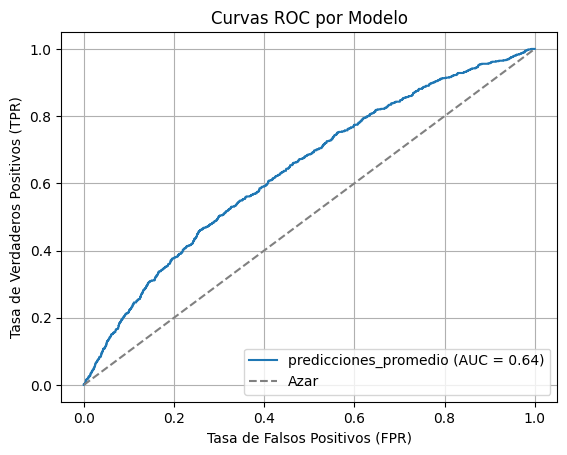

{'predicciones_promedio': {'FPR': array([0.00000000e+00, 8.10110175e-05, 8.10110175e-05, ...,
         9.92384964e-01, 9.92384964e-01, 1.00000000e+00]),
  'TPR': array([0.        , 0.        , 0.00304878, ..., 0.99847561, 1.        ,
         1.        ]),
  'AUC': np.float64(0.6387510027583263)}}

In [26]:
generar_curvas_roc_multiples(dataframes,bajas,13000)

In [27]:
def evaluar_modelos(dataframes, bajas, num_clientes):
    """
    Evalúa y grafica métricas para varios modelos, seleccionando los primeros N clientes.

    Args:
        dataframes (dict): Diccionario donde las claves son los nombres de los modelos y los valores son DataFrames.
                           Cada DataFrame debe tener las columnas ['numero_de_cliente', 'Probabilidad'].
        bajas (DataFrame): DataFrame con las columnas ['numero_de_cliente', 'clase_ternaria'].
                           `clase_ternaria` puede tener los valores 'CONTINUA', 'BAJA+1' y 'BAJA+2'.
        num_clientes (int): Número de clientes a seleccionar (por ejemplo, 13000).

    Returns:
        dict: Diccionario con las métricas calculadas para cada modelo.
    """
    resultados = {}

    for model_name, pred_model in dataframes.items():
        # Ordenar las predicciones por probabilidad descendente
        pred_model_sorted = pred_model.sort_values('Probabilidad', ascending=False)

        # Seleccionar los primeros 'num_clientes' clientes
        pred_model_filtrado = pred_model_sorted.head(num_clientes)

        # Unir con el DataFrame 'bajas' para obtener la clase real
        merged_data = pred_model_filtrado.merge(bajas, on='numero_de_cliente', how='inner')

        # Convertir 'clase_ternaria' en variable binaria: 1 si es 'BAJA+2', 0 en otro caso
        merged_data['bajas_reales'] = (merged_data['clase_ternaria'] == 'BAJA+2').astype(int)

        # Crear la columna de predicciones: Asumimos que todos los seleccionados son predichos como 'BAJA+2'
        merged_data['prediccion'] = 1  # Porque hemos seleccionado estos clientes para enviar el estímulo

        # Obtener las bajas reales y las predicciones
        y_true = merged_data['bajas_reales']
        y_pred = merged_data['prediccion']

        # Calcular métricas
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        f1 = f1_score(y_true, y_pred)

        # Almacenar resultados
        resultados[model_name] = {
            "Verdaderos Positivos (TP)": tp,
            "Falsos Positivos (FP)": fp,
            "Verdaderos Negativos (TN)": tn,
            "Falsos Negativos (FN)": fn,
            "Precisión": precision,
            "Sensibilidad (Recall)": recall,
            "Exactitud (Accuracy)": accuracy,
            "F1-Score": f1,
            "Total Clientes Seleccionados": num_clientes,
            "Total BAJA+2 Reales en Seleccionados": y_true.sum()
        }

    # Mostrar resultados
    for model_name, metrics in resultados.items():
        print(f"\nMétricas para el modelo: {model_name}")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value}")

    return resultados

In [28]:
evaluar_modelos(dataframes, bajas, 13000)


Métricas para el modelo: predicciones_promedio
Verdaderos Positivos (TP): 656
Falsos Positivos (FP): 12344
Verdaderos Negativos (TN): 0
Falsos Negativos (FN): 0
Precisión: 0.05046153846153846
Sensibilidad (Recall): 1.0
Exactitud (Accuracy): 0.05046153846153846
F1-Score: 0.09607498535442296
Total Clientes Seleccionados: 13000
Total BAJA+2 Reales en Seleccionados: 656


{'predicciones_promedio': {'Verdaderos Positivos (TP)': np.int64(656),
  'Falsos Positivos (FP)': np.int64(12344),
  'Verdaderos Negativos (TN)': np.int64(0),
  'Falsos Negativos (FN)': np.int64(0),
  'Precisión': np.float64(0.05046153846153846),
  'Sensibilidad (Recall)': np.float64(1.0),
  'Exactitud (Accuracy)': np.float64(0.05046153846153846),
  'F1-Score': np.float64(0.09607498535442296),
  'Total Clientes Seleccionados': 13000,
  'Total BAJA+2 Reales en Seleccionados': np.int64(656)}}